In [ ]:
!nvidia-smi

Thu Aug  1 13:26:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   44C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
# clone repo
!git clone https://github.com/huazai6161/EC523-Final-Project

Cloning into 'EC523-Final-Project'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 210 (delta 17), reused 0 (delta 0), pack-reused 175
Receiving objects: 100% (210/210), 4.97 MiB | 10.78 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [2]:
# optional: pull changes
# !git pull

In [3]:
# navigate to source directory
%cd EC523-Final-Project/

/content/EC523-Final-Project


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# import necessary packages
from StutterNet import ResNet1D, train, StutterLoss, SEP28KDataset, sigmoid, StutterNet, BCResNet
import numpy as np
import torch
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, hamming_loss
import torchaudio as audio
from torch import nn
from torchvision.transforms import RandomApply

In [6]:
torch.backends.cudnn.benchmark = True

In [7]:
# read the hdf5 dataset
f = h5py.File("/content/drive/MyDrive/SEP28K.hdf5", 'r')

# create train, test, validation splits
trainX, trainY, testX, testY, validX, validY = f['trainX'], f['trainY'], f['testX'], f['testY'], f['validX'], f['validY']

print(trainX.shape, trainY.shape)

print(type(trainX[0]))

# free up dataset
del f

(22537, 48000) (22537, 12)
<class 'numpy.ndarray'>


In [ ]:
import numpy as np

# Count the frequency of 1s in each dimension
names = np.loadtxt('classes.txt', dtype=str)
frequency_of_ones = np.sum(trainY, axis=0)

# Print the frequency for each dimension
for dim, freq in enumerate(frequency_of_ones):
    print(f"Dim {dim}: count = {freq} ({names[dim]})")


Dim 0: count = 465 (PoorAudioQuality)
Dim 1: count = 19 (Unsure)
Dim 2: count = 833 (DifficultToUnderstand)
Dim 3: count = 1924 (NaturalPause)
Dim 4: count = 237 (Music)
Dim 5: count = 247 (NoSpeech)
Dim 6: count = 2269 (Prolongation)
Dim 7: count = 2704 (Block)
Dim 8: count = 1889 (SoundRep)
Dim 9: count = 2207 (WordRep)
Dim 10: count = 4793 (Interjection)
Dim 11: count = 12812 (NoStutteredWords)


In [ ]:
# create required transforms
spec = audio.transforms.MelSpectrogram(n_mels=80, sample_rate=16000,
                                              n_fft=512, f_max=8000, f_min=0,
                                              power=0.5, hop_length=152, win_length=480)
db = audio.transforms.AmplitudeToDB()
transforms = torch.jit.script(nn.Sequential(spec, db))

In [ ]:
# print transforms
print(transforms)

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(
    original_name=MelSpectrogram
    (spectrogram): RecursiveScriptModule(original_name=Spectrogram)
    (mel_scale): RecursiveScriptModule(original_name=MelScale)
  )
  (1): RecursiveScriptModule(original_name=AmplitudeToDB)
)


In [ ]:
# create torch dataset object(s)
train_ds = SEP28KDataset(trainX, trainY, transform=transforms)
test_ds = SEP28KDataset(testX, testY, transform=transforms)
valid_ds = SEP28KDataset(validX, validY, transform=transforms)

In [ ]:
# print number of data points per split
print("size of train set: ", len(train_ds))
print("size of test set: ", len(test_ds))
print("size of val set: ", len(valid_ds))
print("total number of audio clips: ", len(train_ds) + len(test_ds) + len(valid_ds))

size of train set:  22537
size of test set:  2823
size of val set:  2817
total number of audio clips:  28177


/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()


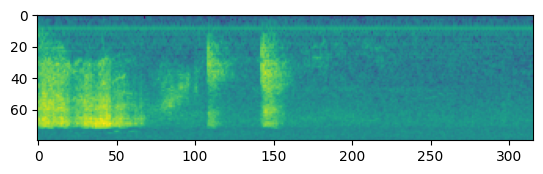

In [ ]:
# visualize a mel spectrogram
import matplotlib.pyplot as plt
plt.imshow(train_ds[0][0])

In [ ]:
# fetch class labels
names = np.loadtxt('classes.txt', dtype=str)
names

array(['PoorAudioQuality', 'Unsure', 'DifficultToUnderstand',
       'NaturalPause', 'Music', 'NoSpeech', 'Prolongation', 'Block',
       'SoundRep', 'WordRep', 'Interjection', 'NoStutteredWords'],
      dtype='<U21')

In [ ]:
# convert labels to list
names = names.tolist()
names

['PoorAudioQuality',
 'Unsure',
 'DifficultToUnderstand',
 'NaturalPause',
 'Music',
 'NoSpeech',
 'Prolongation',
 'Block',
 'SoundRep',
 'WordRep',
 'Interjection',
 'NoStutteredWords']

In [ ]:
# create torch data loaders
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# get device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # get device
print(device)

cuda:0


In [ ]:
import torch
import torch.nn as nn

class MyLoss(nn.Module):
    def __init__(self, pos_weights):
        super(MyLoss, self).__init__()
        # Use 'none' reduction to get individual losses
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weights, reduction='none')
        self.pos_weights = pos_weights

    def forward(self, predictions, labels):
        # Compute the binary cross-entropy loss without reduction
        bce_loss = self.bce_loss(predictions, labels)
        res = 0
        for i in range(12):
          res += bce_loss[:, i] * pos_weights[i]
        res /= 12
        return res.mean()

# Example usage
predictions = torch.randn(64, 12)               # Logits from the model
labels = torch.randint(0, 2, (64, 12)).float()  # Binary labels
pos_weights = torch.ones(12)
loss_fn = MyLoss(pos_weights)
loss = loss_fn(predictions, labels)
print(loss.item())

0.8118714094161987


In [ ]:
import math

# initialize and train our network w/ CCC + Focal Loss and SGD
EPOCHS = 10
steps_per_epoch = math.ceil(len(train_ds) / batch_size)

# net = ResNet1D(80, kernel_size=21).to(device)
net = StutterNet(80, dropout=0.2).to(device)

# Dim 0: count = 465 (PoorAudioQuality)
# Dim 1: count = 19 (Unsure)
# Dim 2: count = 833 (DifficultToUnderstand)
# Dim 3: count = 1924 (NaturalPause)
# Dim 4: count = 237 (Music)
# Dim 5: count = 247 (NoSpeech)
# Dim 6: count = 2269 (Prolongation)
# Dim 7: count = 2704 (Block)
# Dim 8: count = 1889 (SoundRep)
# Dim 9: count = 2207 (WordRep)
# Dim 10: count = 4793 (Interjection)
# Dim 11: count = 12812 (NoStutteredWords)

path = "/content/drive/MyDrive/StutterNet.pth"
# path = None

start_epoch = 0
if path is not None:
  state = torch.load(path)
  start_epoch = state['epoch']

pos_weights = torch.tensor([0.1, 0.1, 0.1, 0.3, 0.5, 0.6, 2, 2, 2, 1.8, 2, 2.5]).to(device)
criterion = MyLoss(pos_weights)
optimizer = torch.optim.SGD(net.parameters(), lr=0.00005, momentum=0.8)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=steps_per_epoch,
                                                epochs=EPOCHS, div_factor=10000, cycle_momentum=False,
                                                pct_start=0.1, anneal_strategy='cos')
train(net, train_loader, criterion, batch_size, names, validationloader=val_loader, optimizer=optimizer, scheduler=scheduler, epochs=EPOCHS, checkpoint_dir=path)


epoch 31/40


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()


87/89 [============================>.] - ETA: 0s - loss: 0.2608

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.67      0.07      0.12        30
             NoSpeech       0.62      0.16      0.25        32
         Prolongation       0.46      0.11      0.18       279
                Block       0.31      0.13      0.18       330
             SoundRep       0.21      0.25      0.23       228
              WordRep       0.12      0.03      0.05       274
         Interjection       0.45      0.65      0.53       583
     NoStutteredWords       0.61      0.94      0.74      1618

            micro avg       0.52      0.54      0.53      3770
            macro avg       0.29      0.19      0.19      3770
         weighted avg       0.42      0.54      0.45 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 0s - loss: 0.3642

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       1.00      0.10      0.18        30
             NoSpeech       0.78      0.22      0.34        32
         Prolongation       0.43      0.07      0.12       279
                Block       0.33      0.08      0.14       330
             SoundRep       0.38      0.07      0.12       228
              WordRep       0.19      0.05      0.08       274
         Interjection       0.47      0.60      0.53       583
     NoStutteredWords       0.59      0.98      0.73      1618

            micro avg       0.55      0.54      0.54      3770
            macro avg       0.35      0.18      0.19      3770
         weighted avg       0.44      0.54      0.44 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 0s - loss: 0.3514

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.32      0.33      0.33        30
             NoSpeech       0.57      0.53      0.55        32
         Prolongation       0.36      0.07      0.12       279
                Block       0.17      0.56      0.26       330
             SoundRep       0.26      0.07      0.10       228
              WordRep       0.33      0.01      0.02       274
         Interjection       0.71      0.28      0.40       583
     NoStutteredWords       0.58      0.96      0.73      1618

            micro avg       0.47      0.52      0.49      3770
            macro avg       0.27      0.23      0.21      3770
         weighted avg       0.45      0.52      0.42 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 0s - loss: 0.4068

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() o

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.30      0.04      0.07       279
                Block       0.14      0.08      0.10       330
             SoundRep       0.40      0.10      0.16       228
              WordRep       0.15      0.01      0.02       274
         Interjection       0.40      0.76      0.53       583
     NoStutteredWords       0.60      0.95      0.73      1618

            micro avg       0.51      0.55      0.53      3770
            macro avg       0.17      0.16      0.13      3770
         weighted avg       0.39      0.55      0.42 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 0s - loss: 0.3190

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.67      0.06      0.11        32
         Prolongation       0.37      0.16      0.23       279
                Block       0.26      0.27      0.26       330
             SoundRep       0.18      0.42      0.25       228
              WordRep       0.11      0.25      0.16       274
         Interjection       0.49      0.60      0.54       583
     NoStutteredWords       0.66      0.52      0.58      1618

            micro avg       0.41      0.39      0.40      3770
            macro avg       0.23      0.19      0.18      3770
         weighted avg       0.43      0.39      0.40 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 0s - loss: 0.2223

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.23      0.44      0.30       279
                Block       0.18      0.52      0.26       330
             SoundRep       0.35      0.24      0.28       228
              WordRep       0.14      0.26      0.18       274
         Interjection       0.63      0.40      0.49       583
     NoStutteredWords       0.68      0.36      0.47      1618

            micro avg       0.36      0.33      0.34      3770
            macro avg       0.18      0.18      0.17      3770
         weighted avg       0.45      0.33      0.35 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 0s - loss: 0.1392

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.94      0.53      0.68        32
         Prolongation       0.32      0.18      0.23       279
                Block       0.28      0.11      0.16       330
             SoundRep       0.20      0.48      0.28       228
              WordRep       0.12      0.09      0.11       274
         Interjection       0.56      0.56      0.56       583
     NoStutteredWords       0.66      0.70      0.68      1618

            micro avg       0.51      0.45      0.48      3770
            macro avg       0.26      0.22      0.22      3770
         weighted avg       0.45      0.45      0.44 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 0s - loss: 0.0961

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       1.00      0.12      0.22        32
         Prolongation       0.31      0.16      0.21       279
                Block       0.25      0.30      0.27       330
             SoundRep       0.36      0.16      0.22       228
              WordRep       0.16      0.28      0.20       274
         Interjection       0.60      0.45      0.52       583
     NoStutteredWords       0.68      0.50      0.57      1618

            micro avg       0.48      0.35      0.41      3770
            macro avg       0.28      0.17      0.18      3770
         weighted avg       0.47      0.35      0.40 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 0s - loss: 0.0640

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       1.00      0.09      0.17        32
         Prolongation       0.30      0.14      0.19       279
                Block       0.24      0.23      0.23       330
             SoundRep       0.38      0.14      0.20       228
              WordRep       0.14      0.16      0.15       274
         Interjection       0.60      0.46      0.52       583
     NoStutteredWords       0.67      0.56      0.61      1618

            micro avg       0.52      0.36      0.43      3770
            macro avg       0.28      0.15      0.17      3770
         weighted avg       0.47      0.36      0.40 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 0s - loss: 0.0528

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       1.00      0.06      0.12        32
         Prolongation       0.29      0.15      0.19       279
                Block       0.24      0.21      0.22       330
             SoundRep       0.38      0.12      0.19       228
              WordRep       0.13      0.14      0.13       274
         Interjection       0.60      0.49      0.54       583
     NoStutteredWords       0.68      0.58      0.62      1618

            micro avg       0.52      0.37      0.43      3770
            macro avg       0.28      0.15      0.17      3770
         weighted avg       0.47      0.37      0.41 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
# initialize and train our network w/ CCC + Focal Loss and SGD
EPOCHS = 20
steps_per_epoch = math.ceil(len(train_ds) / batch_size)

torch.manual_seed(9649716)
net = StutterNet(80, dropout=0.2, scale=2).to(device)
# net = StutterNet(80, dropout=0.2).to(device)

# Dim 0: count = 465 (PoorAudioQuality)
# Dim 1: count = 19 (Unsure)
# Dim 2: count = 833 (DifficultToUnderstand)
# Dim 3: count = 1924 (NaturalPause)
# Dim 4: count = 237 (Music)
# Dim 5: count = 247 (NoSpeech)
# Dim 6: count = 2269 (Prolongation)
# Dim 7: count = 2704 (Block)
# Dim 8: count = 1889 (SoundRep)
# Dim 9: count = 2207 (WordRep)
# Dim 10: count = 4793 (Interjection)
# Dim 11: count = 12812 (NoStutteredWords)

# path = "/content/drive/MyDrive/StutterNet2.pth"
path = None

start_epoch = 0
if path is not None:
  state = torch.load(path)
  start_epoch = state['epoch']

pos_weights = torch.tensor([0.1, 0.1, 0.1, 0.2, 0.3, 0.3, 2.5, 2, 2.5, 3, 1.2, 2.5]).to(device)
criterion = MyLoss(pos_weights)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.8)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=steps_per_epoch,
                                                epochs=EPOCHS, div_factor=10000, cycle_momentum=False,
                                                pct_start=0.1, anneal_strategy='cos')
train(net, train_loader, criterion, batch_size, names, validationloader=val_loader, optimizer=optimizer, scheduler=scheduler, epochs=EPOCHS, checkpoint_dir=path)


epoch 1/20


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()


87/89 [============================>.] - ETA: 2s - loss: 0.8125

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() o

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.36      0.04      0.07       279
                Block       0.50      0.00      0.01       330
             SoundRep       0.14      0.13      0.14       228
              WordRep       0.41      0.10      0.16       274
         Interjection       0.46      0.22      0.30       583
     NoStutteredWords       0.58      0.99      0.73      1618

            micro avg       0.53      0.48      0.50      3770
            macro avg       0.20      0.12      0.12      3770
         weighted avg       0.43      0.48      0.38 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.7385

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() o

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       1.00      0.03      0.06        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.11      0.53      0.19       279
                Block       0.33      0.01      0.02       330
             SoundRep       0.28      0.11      0.15       228
              WordRep       0.17      0.57      0.27       274
         Interjection       0.28      0.84      0.42       583
     NoStutteredWords       0.61      0.86      0.72      1618

            micro avg       0.35      0.59      0.44      3770
            macro avg       0.23      0.25      0.15      3770
         weighted avg       0.38      0.59      0.42 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.7077

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.77      0.04      0.07       279
                Block       0.27      0.22      0.24       330
             SoundRep       0.08      0.98      0.15       228
              WordRep       0.75      0.03      0.06       274
         Interjection       0.78      0.05      0.09       583
     NoStutteredWords       0.62      0.83      0.71      1618

            micro avg       0.32      0.45      0.37      3770
            macro avg       0.27      0.18      0.11      3770
         weighted avg       0.53      0.45      0.36 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.6951

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() o

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.23      0.18      0.20       279
                Block       0.28      0.30      0.29       330
             SoundRep       0.13      0.68      0.22       228
              WordRep       0.11      0.89      0.20       274
         Interjection       0.53      0.32      0.40       583
     NoStutteredWords       0.70      0.47      0.56      1618

            micro avg       0.28      0.40      0.33      3770
            macro avg       0.17      0.24      0.16      3770
         weighted avg       0.44      0.40      0.37 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.6797

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.17      0.16      0.17       279
                Block       0.42      0.12      0.19       330
             SoundRep       0.11      0.74      0.19       228
              WordRep       0.10      0.96      0.18       274
         Interjection       0.77      0.16      0.26       583
     NoStutteredWords       0.65      0.69      0.67      1618

            micro avg       0.27      0.46      0.34      3770
            macro avg       0.19      0.24      0.14      3770
         weighted avg       0.46      0.46      0.38 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.6725

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.45      0.05      0.08       279
                Block       0.25      0.41      0.31       330
             SoundRep       0.15      0.64      0.24       228
              WordRep       0.13      0.78      0.23       274
         Interjection       0.46      0.60      0.52       583
     NoStutteredWords       0.64      0.85      0.73      1618

            micro avg       0.37      0.59      0.45      3770
            macro avg       0.17      0.28      0.18      3770
         weighted avg       0.42      0.59      0.46 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.6370

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.14      0.70      0.24       279
                Block       0.34      0.25      0.29       330
             SoundRep       0.42      0.16      0.23       228
              WordRep       0.15      0.46      0.22       274
         Interjection       0.50      0.53      0.52       583
     NoStutteredWords       0.67      0.65      0.66      1618

            micro avg       0.38      0.48      0.42      3770
            macro avg       0.19      0.23      0.18      3770
         weighted avg       0.44      0.48      0.44 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.6103

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.33      0.29      0.31       279
                Block       0.21      0.25      0.22       330
             SoundRep       0.23      0.20      0.21       228
              WordRep       0.25      0.21      0.23       274
         Interjection       0.77      0.28      0.41       583
     NoStutteredWords       0.60      0.92      0.73      1618

            micro avg       0.51      0.51      0.51      3770
            macro avg       0.20      0.18      0.18      3770
         weighted avg       0.45      0.51      0.45 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.5960

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.65      0.04      0.07       279
                Block       0.23      0.52      0.32       330
             SoundRep       0.28      0.31      0.29       228
              WordRep       0.12      0.91      0.21       274
         Interjection       0.41      0.71      0.52       583
     NoStutteredWords       0.69      0.58      0.63      1618

            micro avg       0.34      0.49      0.40      3770
            macro avg       0.20      0.26      0.17      3770
         weighted avg       0.45      0.49      0.42 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.5734

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.28      0.22      0.24       279
                Block       0.47      0.12      0.19       330
             SoundRep       0.40      0.23      0.29       228
              WordRep       0.21      0.04      0.06       274
         Interjection       0.75      0.30      0.43       583
     NoStutteredWords       0.62      0.93      0.74      1618

            micro avg       0.58      0.49      0.53      3770
            macro avg       0.23      0.15      0.16      3770
         weighted avg       0.48      0.49      0.44 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.5254

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.22      0.55      0.31       279
                Block       0.43      0.05      0.09       330
             SoundRep       0.25      0.14      0.18       228
              WordRep       0.14      0.57      0.23       274
         Interjection       0.46      0.66      0.54       583
     NoStutteredWords       0.63      0.85      0.72      1618

            micro avg       0.43      0.56      0.48      3770
            macro avg       0.18      0.23      0.17      3770
         weighted avg       0.42      0.56      0.45 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.5116

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.33      0.17      0.22       279
                Block       0.33      0.20      0.25       330
             SoundRep       0.22      0.29      0.25       228
              WordRep       0.17      0.39      0.23       274
         Interjection       0.49      0.50      0.49       583
     NoStutteredWords       0.67      0.62      0.64      1618

            micro avg       0.47      0.42      0.44      3770
            macro avg       0.19      0.18      0.18      3770
         weighted avg       0.44      0.42      0.42 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.4458

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.25      0.24      0.24       279
                Block       0.35      0.02      0.05       330
             SoundRep       0.37      0.07      0.12       228
              WordRep       0.17      0.58      0.26       274
         Interjection       0.52      0.56      0.54       583
     NoStutteredWords       0.62      0.89      0.73      1618

            micro avg       0.48      0.53      0.50      3770
            macro avg       0.19      0.20      0.16      3770
         weighted avg       0.43      0.53      0.44 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.4072

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.22      0.33      0.27       279
                Block       0.26      0.19      0.22       330
             SoundRep       0.24      0.40      0.30       228
              WordRep       0.11      0.64      0.19       274
         Interjection       0.57      0.49      0.53       583
     NoStutteredWords       0.71      0.36      0.48      1618

            micro avg       0.32      0.34      0.33      3770
            macro avg       0.18      0.20      0.16      3770
         weighted avg       0.45      0.34      0.36 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.4304

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.59      0.10      0.18       279
                Block       0.47      0.05      0.10       330
             SoundRep       0.44      0.07      0.12       228
              WordRep       0.15      0.57      0.24       274
         Interjection       0.79      0.26      0.39       583
     NoStutteredWords       0.61      0.91      0.73      1618

            micro avg       0.49      0.49      0.49      3770
            macro avg       0.26      0.16      0.15      3770
         weighted avg       0.51      0.49      0.42 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.3369

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.28      0.26      0.27       279
                Block       0.19      0.23      0.21       330
             SoundRep       0.26      0.27      0.27       228
              WordRep       0.19      0.50      0.28       274
         Interjection       0.62      0.41      0.50       583
     NoStutteredWords       0.68      0.51      0.58      1618

            micro avg       0.44      0.38      0.41      3770
            macro avg       0.19      0.18      0.18      3770
         weighted avg       0.45      0.38      0.40 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.2436

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.25      0.34      0.29       279
                Block       0.26      0.25      0.25       330
             SoundRep       0.39      0.12      0.19       228
              WordRep       0.18      0.38      0.24       274
         Interjection       0.59      0.45      0.51       583
     NoStutteredWords       0.68      0.56      0.61      1618

            micro avg       0.47      0.39      0.43      3770
            macro avg       0.20      0.17      0.17      3770
         weighted avg       0.46      0.39      0.41 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.2086

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.35      0.20      0.25       279
                Block       0.28      0.24      0.26       330
             SoundRep       0.35      0.21      0.27       228
              WordRep       0.17      0.35      0.23       274
         Interjection       0.61      0.39      0.48       583
     NoStutteredWords       0.68      0.59      0.63      1618

            micro avg       0.50      0.39      0.44      3770
            macro avg       0.20      0.17      0.18      3770
         weighted avg       0.47      0.39      0.42 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.1762

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.32      0.23      0.27       279
                Block       0.25      0.18      0.21       330
             SoundRep       0.39      0.16      0.23       228
              WordRep       0.17      0.25      0.21       274
         Interjection       0.62      0.40      0.49       583
     NoStutteredWords       0.67      0.61      0.64      1618

            micro avg       0.53      0.39      0.45      3770
            macro avg       0.20      0.15      0.17      3770
         weighted avg       0.47      0.39      0.42 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

87/89 [============================>.] - ETA: 2s - loss: 0.1624

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

                       precision    recall  f1-score   support

     PoorAudioQuality       0.00      0.00      0.00        58
               Unsure       0.00      0.00      0.00         2
DifficultToUnderstand       0.00      0.00      0.00       106
         NaturalPause       0.00      0.00      0.00       230
                Music       0.00      0.00      0.00        30
             NoSpeech       0.00      0.00      0.00        32
         Prolongation       0.32      0.22      0.26       279
                Block       0.24      0.21      0.22       330
             SoundRep       0.40      0.15      0.22       228
              WordRep       0.17      0.26      0.21       274
         Interjection       0.60      0.43      0.50       583
     NoStutteredWords       0.67      0.59      0.63      1618

            micro avg       0.51      0.38      0.44      3770
            macro avg       0.20      0.16      0.17      3770
         weighted avg       0.46      0.38      0.41 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
# prediction and groundtruth placeholders
preds = np.zeros((len(test_ds), 12))
gt = np.zeros((len(test_ds), 12))

# prediction counter
idx = 0

# set model to evaluation mode
net.eval()

# perform inference
for data in iter(test_loader):
  # get features and labels
  inputs, labels = data[0].to(device), data[1].detach().cpu().numpy()

  # get predictions
  outputs = net(inputs).detach().cpu().numpy()

  # store predictions and labels
  preds[idx:idx+batch_size, :] = outputs
  gt[idx:idx+batch_size, :] = labels

  # increment counter
  idx += batch_size

# print metrics
preds = (sigmoid(preds) > 0.5).astype('int')
gt = gt.astype('int')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()


In [ ]:
# You should check the results in this way,
# or write your own functions if you want
for i in range(12):
    print(f"Classification report for {names[i]} (dim = {i}):")
    print(classification_report(gt[:, i], preds[:, i], zero_division=1))
    print("\n")

Classification report for PoorAudioQuality (dim = 0):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2764
           1       1.00      0.00      0.00        59

    accuracy                           0.98      2823
   macro avg       0.99      0.50      0.49      2823
weighted avg       0.98      0.98      0.97      2823



Classification report for Unsure (dim = 1):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2820
           1       1.00      0.00      0.00         3

    accuracy                           1.00      2823
   macro avg       1.00      0.50      0.50      2823
weighted avg       1.00      1.00      1.00      2823



Classification report for DifficultToUnderstand (dim = 2):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2724
           1       1.00      0.00      0.00        99

    accuracy         

In [ ]:
# save the model
path = "/content/drive/MyDrive/StutterNet2.pth"
state = {
    'epoch': start_epoch + EPOCHS,
    'state_dict': net.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(state, path)

In [ ]:
# ensemble learning
state = torch.load("/content/drive/MyDrive/StutterNet2.pth")
net1 = StutterNet(80, dropout=0.2, scale=2).to(device)
net1.load_state_dict(state['state_dict'])
net1.eval()

state = torch.load("/content/drive/MyDrive/StutterNet.pth")
net2 = StutterNet(80, dropout=0.2).to(device)
net2.load_state_dict(state['state_dict'])
net2.eval()

# prediction and groundtruth placeholders
preds = np.zeros((len(test_ds), 12))
gt = np.zeros((len(test_ds), 12))

# prediction counter
idx = 0

# perform inference
for data in iter(test_loader):
  # get features and labels
  inputs, labels = data[0].to(device), data[1].detach().cpu().numpy()

  # get predictions
  outputs = (net1(inputs).detach().cpu().numpy() + net2(inputs).detach().cpu().numpy()) / 2

  # store predictions and labels
  preds[idx:idx+batch_size, :] = outputs
  gt[idx:idx+batch_size, :] = labels

  # increment counter
  idx += batch_size

# print metrics
preds = (sigmoid(preds) > 0.5).astype('int')
gt = gt.astype('int')

for i in range(12):
    print(f"Classification report for {names[i]} (dim = {i}):")
    print(classification_report(gt[:, i], preds[:, i], zero_division=1))
    print("\n")

/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()
/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()


Classification report for PoorAudioQuality (dim = 0):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2764
           1       1.00      0.00      0.00        59

    accuracy                           0.98      2823
   macro avg       0.99      0.50      0.49      2823
weighted avg       0.98      0.98      0.97      2823



Classification report for Unsure (dim = 1):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2820
           1       1.00      0.00      0.00         3

    accuracy                           1.00      2823
   macro avg       1.00      0.50      0.50      2823
weighted avg       1.00      1.00      1.00      2823



Classification report for DifficultToUnderstand (dim = 2):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2724
           1       1.00      0.00      0.00        99

    accuracy         